In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['giantsteps-key-dataset', 'apple_loops_db', 'mixcraft_loops_db']
datasets = load_datasets(dirnames=dataset_dirnames, clean=True, exclude_files=['analysis_freesound_extractor_04.json'])  # Load and clean datasets
methods_to_compare = ['ACExtractorV1', 'EdmkeyShaath', 'EdmkeyKrumhansl', 'EdmkeyTemperley', 'QMULKeyDetector']
accuracy_functions = [mireval_key_same, mireval_key_fifth, mireval_key_relative, mireval_key_parallel, mireval_key_weighted_score]
accuracy_functions_names = ['Same', 'Fifth', 'Relative', 'Parallel', 'Mirex']

DISPLAY_NAMES = {
'EdmkeyShaath': 'EDMKey1',
'EdmkeyKrumhansl': 'EDMKey2',
'EdmkeyTemperley': 'EDMKey3',
'ACExtractorV1': 'ACExtractorV1',
'QMULKeyDetector': 'QMULKey',
}


Basic statistics per dataset
----------------------------

Dataset   N      T. Duration   Mean Duration   Durations range    
------------------------------------------------------------------
GSKY      604    20h 4m        119.61s         44.70s - 120.01s   
APPL      2743   6h 15m        8.21s           2.07s - 40.05s     
MIXL      2935   9h 37m        11.80s          0.86s - 82.29s     


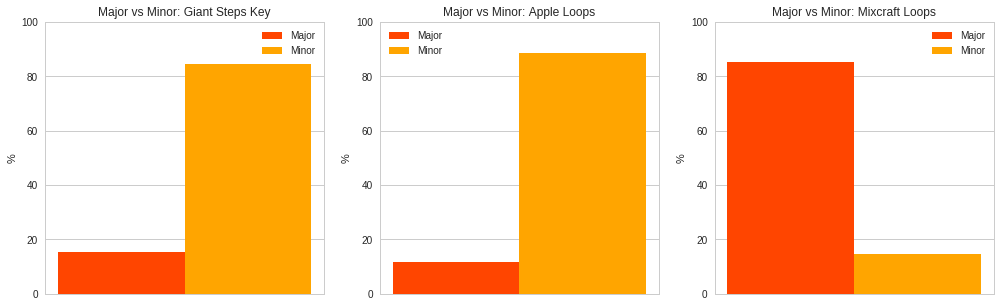

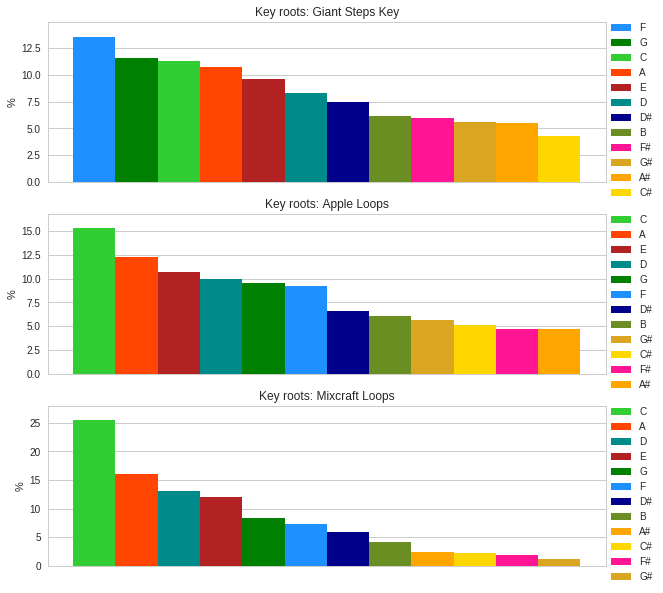

In [2]:
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    if durations:
        durations = np.array(durations)
        row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
        row.append('%.2fs' % durations.mean())
        row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    table_rows.append(row)

print(title('Basic statistics per dataset'))
print_table(table_header, table_rows, highlight_max=False)

# Key major/minor bars
fig1, axs = plt.subplots(1, 3, figsize=(17, 5))
for count, dataset in enumerate(datasets):
    keys = dataset.get_data('annotations.key')
    total = len(keys)
    major_minor = [len([key for key in keys if 'major' in key])*100.0/total, len([key for key in keys if 'minor' in key])*100.0/total]
    ax = axs[count]
    ax.bar(1, major_minor[0], 1, color=COLORS[0], label='Major')
    ax.bar(2, major_minor[1], 1, color=COLORS[1], label='Minor')
    ax.set_ylabel('%')
    ax.set_ylim((0, 100))
    ax.set_xticks([])
    ax.set_title('Major vs Minor: %s' % dataset.name)
    ax.legend()
plt.show()


# Key root histogram
from collections import Counter
from ac_utils.music import root_to_num, num_to_root

fig1, axs = plt.subplots(3, 1, figsize=(10, 10))
for count, dataset in enumerate(datasets):
    keys = dataset.get_data('annotations.key')
    roots = [num_to_root(root_to_num(key.split(' ')[0])) for key in keys]
    roots_counts = Counter(roots).most_common()
    total = len(roots)
    ax = axs[count]
    for ind, (root, rcount) in enumerate(roots_counts):
        key_color = COLORS[root_to_num(root)]
        ax.bar(ind, rcount*100.0/total, 1, color=key_color, label=root)
    ax.set_ylabel('%')
    ax.set_ylim((0, (roots_counts[0][1]*100.0/total)*1.1))
    ax.set_xticks([])
    ax.set_title('Key roots: %s' % dataset.name)
    ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()







General key estimation results (GSKY)
**************************************


Method          Same    Fifth   Relative   Parallel   Mirex   
--------------------------------------------------------------
EDMKey1         55.46   6.46    7.62       14.07      63.79   
EDMKey2         47.85   8.77    8.77       15.40      57.95   
EDMKey3         47.35   4.14    13.74      8.11       55.17   
ACExtractorV1   34.11   2.65    8.44       7.12       39.39   
QMULKey         30.63   8.11    12.75      5.13       39.54   


General key estimation results (APPL)
**************************************


Method          Same    Fifth   Relative   Parallel   Mirex   
--------------------------------------------------------------
EDMKey1         38.53   8.28    7.00       13.23      47.42   
EDMKey2         34.09   9.84    8.24       14.69      44.42   
EDMKey3         28.98   5.58    13.45      8.68       37.54   
ACExtractorV1   26.47   4.05    9.26       5.25       32.32   
QMULKey         26.

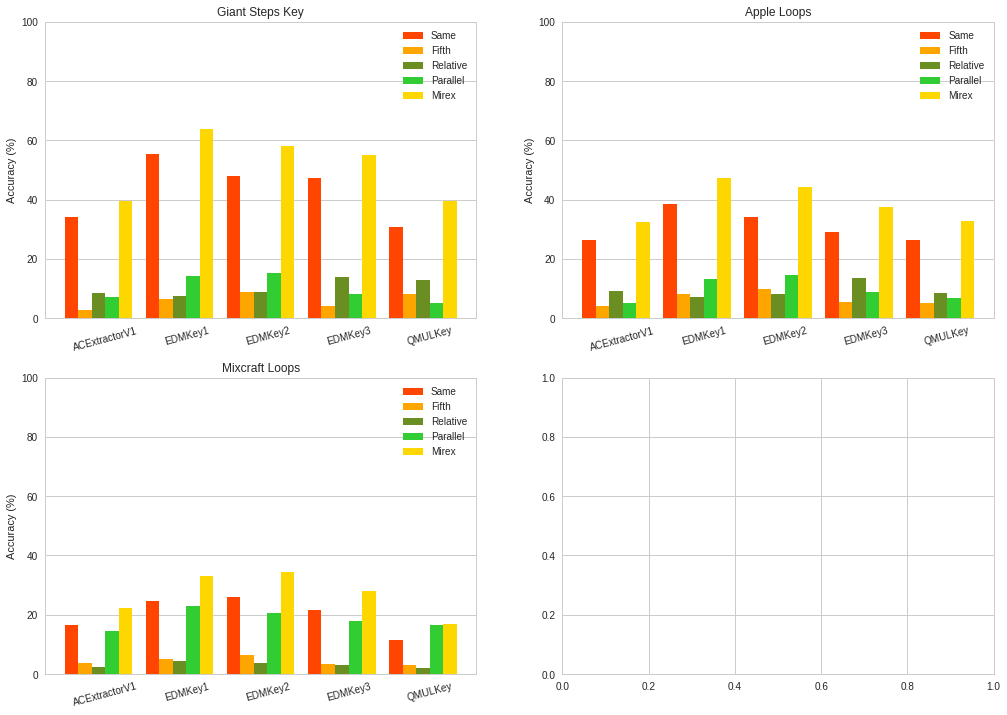

In [3]:
all_datasets_method_results = dict()
fig1, axs = plt.subplots(2, 2, figsize=(17, 12))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral key estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [DISPLAY_NAMES.get(method, method) ]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_rows.append(table_row)
        except IndexError as e:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    ax = axs[count//2,count%2]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method)  for method in methods_to_compare], rotation=15)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [4]:
print(title("General key estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [DISPLAY_NAMES.get(method, method) ]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row)
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)



General key estimation results (ALL DATASETS)
---------------------------------------------

Method          Same    Fifth   Relative   Parallel   Mirex   
--------------------------------------------------------------
EDMKey1         33.60   6.59    5.83       17.89      42.23   
EDMKey2         31.60   8.07    6.19       17.54      41.00   
EDMKey3         27.33   4.44    8.56       12.99      34.72   
ACExtractorV1   22.64   3.71    5.97       9.79       28.24   
QMULKey         19.82   4.44    5.91       11.16      26.04   


In [5]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print("")
    print(title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy_functions:
        print('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [DISPLAY_NAMES.get(method, method) for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([DISPLAY_NAMES.get(method_a, method_a) ] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset GSKY
----------------------------------


Measure: mireval_key_same
                ACExtractorV1   EDMKey1     EDMKey2     EDMKey3     QMULKey     
--------------------------------------------------------------------------------
ACExtractorV1   -               1.74e-19*   1.35e-09*   1.94e-10*   0.156       
EDMKey1         1.74e-19*       -           9.14e-10*   1.76e-05*   4.54e-22*   
EDMKey2         1.35e-09*       9.14e-10*   -           0.853       4.75e-12*   
EDMKey3         1.94e-10*       1.76e-05*   0.853       -           1.04e-12*   
QMULKey         0.156           4.54e-22*   4.75e-12*   1.04e-12*   -           

Measure: mireval_key_fifth
                ACExtractorV1   EDMKey1    EDMKey2     EDMKey3     QMULKey     
-------------------------------------------------------------------------------
ACExtractorV1   -               4.4e-05*   1.88e-08*   0.0389      4.84e-06*   
EDMKey1         4.4e-05*        -          0.00365*    0.0108    